In [60]:
import os
import re
from data_utils.loaders import load_files
import pandas as pd
import numpy as np
import einx
import matplotlib.pyplot as plt

In [2]:
folder = "data/collected_data/"

In [4]:
def load_files(folder):
	d = {}
	subjects = []
	files = os.listdir(folder)
	for i in files:
		subject = str.split(i,"_")[0]
		if re.fullmatch(r"^s\d+$",subject):
			df = pd.read_csv(os.path.join(folder,i))
			if subject not in d.keys():
				d[subject] = [df]
				subjects.append(subject)
			else:
				d[subject].append(df)
		else:
			print(subject)
	for s in subjects:
		d[s] = {"train":d[s][:-1],"test":[d[s][-1]]}
	return d


In [5]:
data = load_files(folder)

BrainFlow-RAW


Subject information.xlsx


In [7]:
def _get_epochs(df,
				indices,
				n_samples_baseline,
				n_samples,
				subject_channels,
				epochs = [],):
		c = 0
		for i in indices:

			epoch = df.loc[i-n_samples_baseline:i+n_samples][subject_channels]
			epochs.append(epoch)
			c+=1

		return epochs

In [47]:
def get_epochs(dfs,
			   fs,
			   t_epoch,
			   subject_channels,
			   labels,
			   t_baseline=0,):
	
	epoch_list = {i:[] for i in labels}

	n_samples = int(fs*t_epoch)
	n_samples_baseline = int(fs*t_baseline)

	for df in dfs:

		indices = np.arange(len(df))

		for i in labels:
			prev_0 = (df[i].shift(1) == 0)
			current_1 = (df[i] == 1)
			intersection = prev_0 & current_1
			print(intersection.sum())

			label_idx = indices[intersection]
			epoch_list[i] = _get_epochs(df,label_idx,n_samples_baseline,
							   n_samples,epochs=epoch_list[i],subject_channels=subject_channels)
			
	for i in labels:
		epoch_list[i] = np.stack(epoch_list[i],0)
	return epoch_list

In [79]:
labels = [f"image_{i}" for i in range(1,5)]

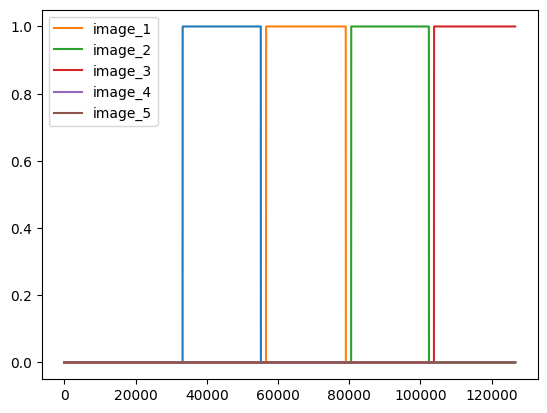

In [89]:
subject = "s1"
plt.plot(data[subject]["test"][0]["image_0"])
for l in labels:
	plt.plot(data[subject]["test"][0][l],label=l)
plt.legend()
plt.show()

In [41]:
def sliding_window_view(arr, window_size, step, axis):
	shape = arr.shape[:axis] + ((arr.shape[axis] - window_size) // step + 1, window_size) + arr.shape[axis+1:]
	strides = arr.strides[:axis] + (arr.strides[axis] * step, arr.strides[axis]) + arr.strides[axis+1:]
	strided = np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)
	return einx.rearrange("n e ... -> (n e) ...",strided)

In [42]:
def subject_epochs(dfs,
				   labels,
				   subject_channels,
				   stride=25,
				   epoch_length=512):
	epoch_list = get_epochs(dfs=dfs,
						 fs=256,
						 t_epoch=8,
						 subject_channels=subject_channels,
						 labels=labels,
						 t_baseline=0)
	
	xs = []
	ys = []

	c = 0

	for key,value in epoch_list.items():
		print(value.shape)
		epochs = sliding_window_view(value,epoch_length,stride,1)
		y = np.ones(len(epochs))*c
		xs.append(epochs)
		ys.append(y)

	xs = np.concatenate(xs,0)
	ys = np.concatenate(ys,0)

	return xs,ys

In [74]:
x,y = subject_epochs(dfs=data["s1"]["test"],
				   labels=[f"image_{i}" for i in range(4)],
				   subject_channels=[f"ch{i}" for i in range(1,9)],
				   stride=25,
				   epoch_length=512)

1
1
1
1
(1, 2049, 8)
(1, 2049, 8)
(1, 2049, 8)
(1, 2049, 8)
